In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [3]:
data_1 = pd.read_json("C:/Users/Kavanak/Downloads/archive (6)/Sarcasm_Headlines_Dataset.json", lines=True)
data_2 = pd.read_json("C:/Users/Kavanak/Downloads/archive (6)/Sarcasm_Headlines_Dataset_v2.json", lines=True)  #pandas helpfull in concating datasets
data =  pd.concat([data_1, data_2])
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emotions
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [5]:
import nltk
nltk.download('punkt')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kavanak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kavanak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
import string 
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords 

def CleanTokenize(df):
    head_lines = list() 
    lines = df["headline"].values.tolist()

    for line in lines: 
        line = clean_text(line)
        # tokenize the text  
        tokens = word_tokenize(line) 
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens] 
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()] 
        stop_words = set(stopwords.words("english")) 
        # remove stop words 
        words = [w for w in words if not w in stop_words] 
        head_lines.append(words) 
    return head_lines

head_lines = CleanTokenize(data)
head_lines[0:10]

[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  'black',
  'code',
  'minority',
  'shoppers'],
 ['roseanne',
  'revival',
  'catches',
  'thorny',
  'political',
  'mood',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  'sons',
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen',
  'come',
  'alternative',
  'debtreduction',
  'ideas'],
 ['jk', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'magical', 'way'],
 ['advancing', 'worlds', 'women'],
 ['fascinating', 'case', 'eating', 'labgrown', 'meat'],
 ['ceo', 'send', 'kids', 'school', 'work', 'company'],
 ['top', 'snake', 'handler', 'leaves', 'sinking', 'huckabee', 'campaign'],
 ['fridays', 'morning', 'email', 'inside', 'trumps', 'presser', 'ages']]

Visualize the most occuring words

In [8]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


(-0.5, 999.5, 499.5, -0.5)

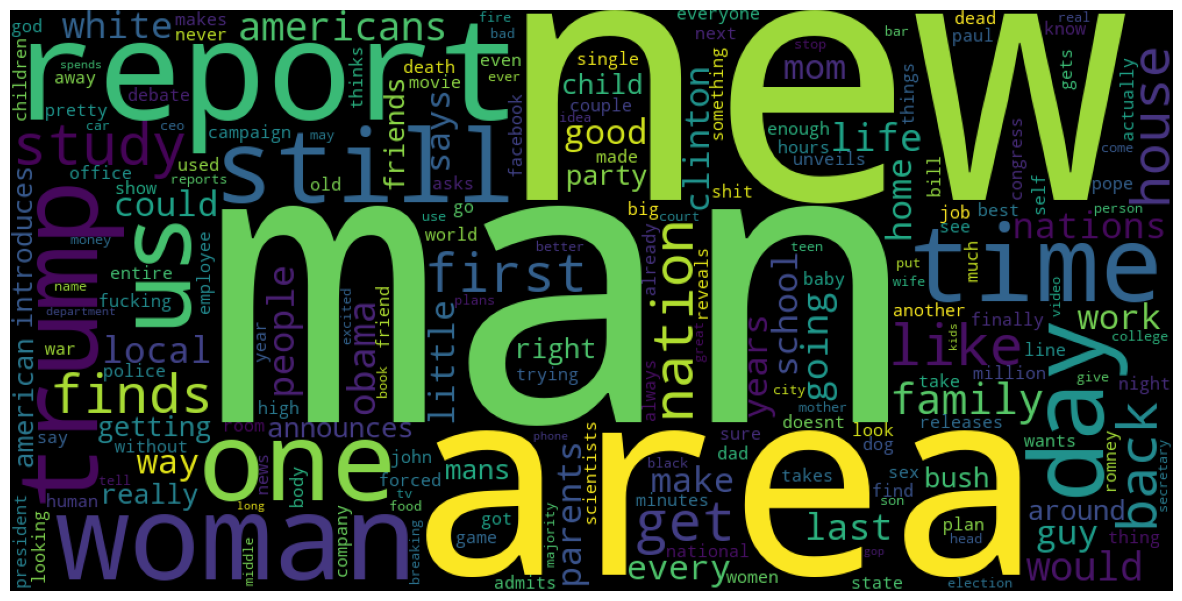

In [9]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data.loc[data['is_sarcastic'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

Train-test split

In [10]:
validation_split = 0.2
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['is_sarcastic'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  28657
vocab size - 28658


In [11]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (44263, 25)
Shape of y_train: (44263,)
Shape of X_test_pad: (11065, 25)
Shape of y_test: (11065,)


Load GloVe model

In [12]:
import numpy as np 
import pandas as pd 
import os
import re

In [13]:
import os
embeddings_index = {}
embedding_dim = 100
GLOVE_DIR = "C:/Users/Kavanak/Downloads/glove.twitter.27B"
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.100d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


Build the embedding layer

In [14]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

24755


In [15]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

C:\Users\Kavanak\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Build the RNN

In [16]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       2,865,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,865,800 (10.93 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,865,800 (10.93 MB)

None


Training

In [17]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)


Epoch 1/25
1384/1384 - 36s - 26ms/step - acc: 0.7211 - loss: 0.5562 - val_acc: 0.7864 - val_loss: 0.4553
Epoch 2/25
1384/1384 - 43s - 31ms/step - acc: 0.7676 - loss: 0.4906 - val_acc: 0.8023 - val_loss: 0.4311
Epoch 3/25
1384/1384 - 28s - 21ms/step - acc: 0.7868 - loss: 0.4569 - val_acc: 0.8192 - val_loss: 0.4012
Epoch 4/25
1384/1384 - 27s - 19ms/step - acc: 0.8006 - loss: 0.4351 - val_acc: 0.8282 - val_loss: 0.3808
Epoch 5/25
1384/1384 - 42s - 30ms/step - acc: 0.8069 - loss: 0.4191 - val_acc: 0.8368 - val_loss: 0.3694
Epoch 6/25
1384/1384 - 29s - 21ms/step - acc: 0.8172 - loss: 0.4038 - val_acc: 0.8387 - val_loss: 0.3584
Epoch 7/25
1384/1384 - 27s - 20ms/step - acc: 0.8231 - loss: 0.3893 - val_acc: 0.8445 - val_loss: 0.3597
Epoch 8/25
1384/1384 - 42s - 31ms/step - acc: 0.8299 - loss: 0.3800 - val_acc: 0.8497 - val_loss: 0.3460
Epoch 9/25
1384/1384 - 39s - 28ms/step - acc: 0.8355 - loss: 0.3694 - val_acc: 0.8571 - val_loss: 0.3300
Epoch 10/25
1384/1384 - 41s - 30ms/step - acc: 0.8371 -

Visualize the learning

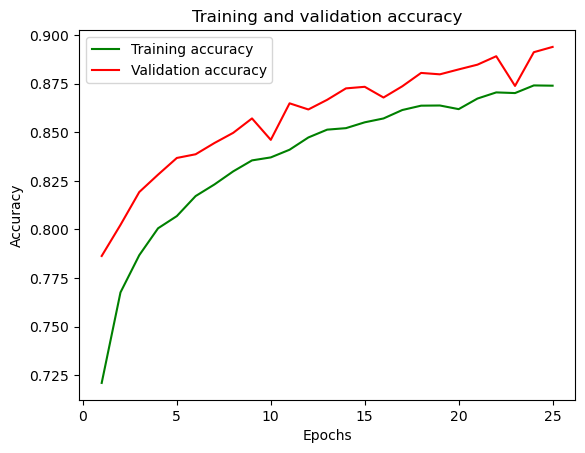

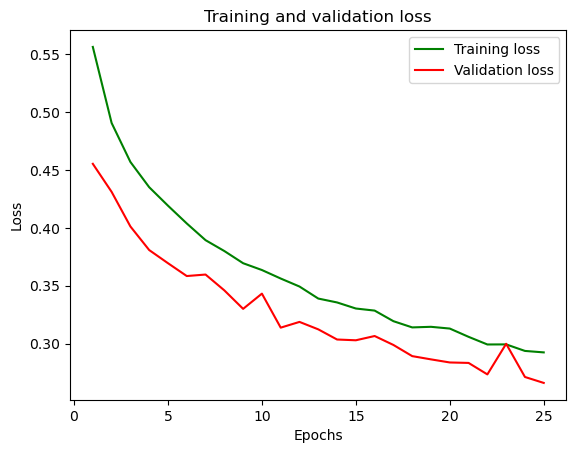

In [18]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')  # Add x-axis label
plt.ylabel('Loss')
plt.legend()

plt.show()

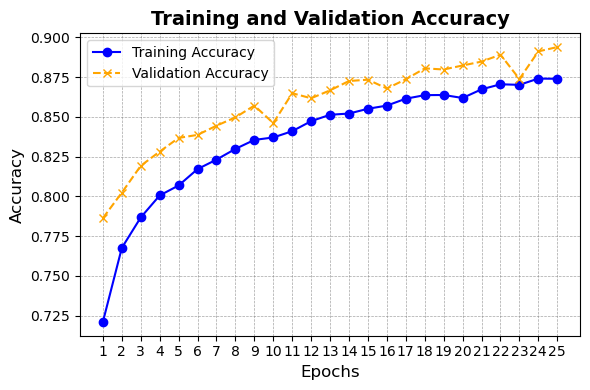

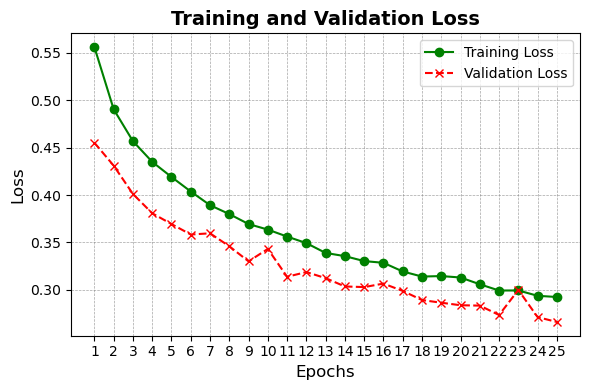

In [22]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(6, 4))
plt.plot(epochs, acc, marker='o', linestyle='-', color='blue', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='x', linestyle='--', color='orange', label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(epochs)  # Ensure all epochs are labeled on the x-axis
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(6, 4))
plt.plot(epochs, loss, marker='o', linestyle='-', color='green', label='Training Loss')
plt.plot(epochs, val_loss, marker='x', linestyle='--', color='red', label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(epochs)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  
   is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 de

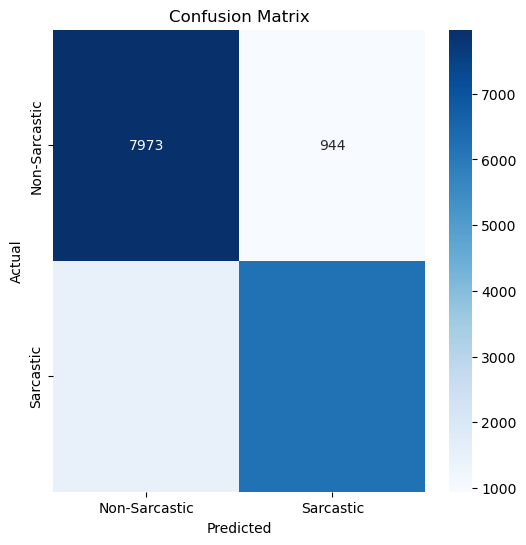

Confusion Matrix:
[[7973  944]
 [1478 6204]]

Classification Report:
               precision    recall  f1-score   support

Non-Sarcastic       0.84      0.89      0.87      8917
    Sarcastic       0.87      0.81      0.84      7682

     accuracy                           0.85     16599
    macro avg       0.86      0.85      0.85     16599
 weighted avg       0.85      0.85      0.85     16599



In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Check the column names and the first few rows
print(data_1.head())
print(data_2.head())
#print(data.columns)
#print(data.head())
data = pd.concat([data_1[['headline', 'is_sarcastic']], data_2[['headline', 'is_sarcastic']]])

# Check the merged data
print(data.head())

# Step 1: Preprocessing the data (vectorize the text)
X = data['headline']  # Replace with the actual column name for the headlines
y = data['is_sarcastic']  # Labels

# Using TF-IDF vectorizer to convert text to numerical features
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(X)

# Step 2: Train a model (Logistic Regression for this example)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

# Step 3: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 4: Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 5: Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Sarcastic', 'Sarcastic'], yticklabels=['Non-Sarcastic', 'Sarcastic'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print confusion matrix values and predictions for analysis
print("Confusion Matrix:")
print(cm)

# You can also print a classification report to see precision, recall, etc.
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Sarcastic', 'Sarcastic']))

                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  
   is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 de

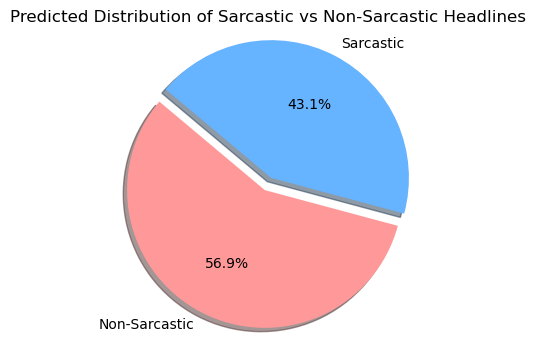


Classification Report:
               precision    recall  f1-score   support

Non-Sarcastic       0.84      0.89      0.87      8917
    Sarcastic       0.87      0.81      0.84      7682

     accuracy                           0.85     16599
    macro avg       0.86      0.85      0.85     16599
 weighted avg       0.85      0.85      0.85     16599



In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Check the column names and the first few rows
print(data_1.head())
print(data_2.head())

data = pd.concat([data_1[['headline', 'is_sarcastic']], data_2[['headline', 'is_sarcastic']]])

# Check the merged data
print(data.head())

# Step 1: Preprocessing the data (vectorize the text)
X = data['headline']  # Replace with the actual column name for the headlines
y = data['is_sarcastic']  # Labels

# Using TF-IDF vectorizer to convert text to numerical features
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(X)

# Step 2: Train a model (Logistic Regression for this example)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

# Step 3: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 4: Generate the pie chart based on the predicted values
labels = ['Non-Sarcastic', 'Sarcastic']
sizes = [sum(y_pred == 0), sum(y_pred == 1)]  # Count of non-sarcastic and sarcastic predictions
colors = ['#ff9999', '#66b3ff']  # Colors for each category
explode = (0.1, 0)  # 'explode' the first slice (Non-Sarcastic)

# Generate the pie chart
plt.figure(figsize=(4, 4))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Predicted Distribution of Sarcastic vs Non-Sarcastic Headlines')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.show()

# Print a classification report to see precision, recall, etc.
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Sarcastic', 'Sarcastic']))

Can this model detect sarcasms?

In [28]:
import pickle

# Save the vectorizer
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [29]:
import numpy as np

def predict_sarcasm(s):
    # Convert the input string to a numerical feature vector
    test_vector = vectorizer.transform([s])  # Use the loaded vectorizer

    # Ensure the input is the correct shape for the model
    pred = model.predict(test_vector)  # Predict sarcasm (0 or 1)

    # Scale prediction to percentage if needed
    prob = model.predict_proba(test_vector) * 100
    if pred[0] == 1:
        return f"It's sarcasm! Confidence: {prob[0][1]:.2f}%"
    else:
        return f"It's not sarcasm! Confidence: {prob[0][0]:.2f}%"

In [30]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"headline":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    #with 
    #contextlib.redirect_stdout(io.StringIO())
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's a sarcasm!" 
    else: return "It's not a sarcasm."

Correct guesses

In [ ]:
predict_sarcasm("You just broke my car window. Great job.")  